<a href="https://colab.research.google.com/github/lakshaygola/Gans/blob/main/Anime_Faces(GANs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('gans-anime-faces')
jovian.set_colab_id('1bcDQBG_wEvkyp8eUNMqDRoHTvAAZ-fsU')

In [ ]:
!pip install jovian --upgrade --quiet
!pip install opendatasets --upgrade --quiet

In [ ]:
project_name= 'gans-anime-faces'

## Downloading the dataset

In the dataset we have the anime faces which we will use to generate the fake anime faces

**Dataset link**

https://www.kaggle.com/splcher/animefacedataset

You can download the dataset if you want to work on this dataset

In [ ]:
# Downloading the dataset from the kaggle (anime faces dataset)
import opendatasets as od

dataset_url= 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lakshaygola
Your Kaggle Key: ··········


  0%|          | 0.00/395M [00:00<?, ?B/s]

100%|██████████| 395M/395M [00:06<00:00, 62.1MB/s]


In [ ]:
# Saving the working directory
import os

data_dir= './animefacedataset'
print(os.listdir(data_dir))

['images']


In [ ]:
# checking the element of the directory
print(os.listdir(data_dir+'/images')[:20])

['61043_2018.jpg', '39781_2012.jpg', '20106_2007.jpg', '12368_2005.jpg', '44791_2013.jpg', '53729_2016.jpg', '2390_2001.jpg', '14622_2006.jpg', '3059_2002.jpg', '5128_2003.jpg', '57801_2017.jpg', '25042_2009.jpg', '50651_2015.jpg', '12214_2005.jpg', '51568_2015.jpg', '52298_2015.jpg', '60676_2018.jpg', '24596_2009.jpg', '33913_2011.jpg', '53395_2016.jpg']


In [ ]:
# Importing some necessary library
from torchvision import transforms as tt
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [ ]:
# To perform the normalization of the images and the size of the image need for the model
stats= (0.5,0.5,0.5), (0.5,0.5,0.5)
batch_size= 130
image_size= 64

## PreProcessing

Normalizing the data and performing the transformation

Resize - To resize the image of the images_size

CerterCrop - To crop the image from the centre

In [ ]:
train_data= ImageFolder(data_dir, transform= tt.Compose([
                                                         tt.Resize(image_size), 
                                                         tt.CenterCrop(image_size), 
                                                         tt.ToTensor(), 
                                                         tt.Normalize(*stats)]))

In [ ]:
train_loader= DataLoader(train_data, batch_size, shuffle= True, pin_memory=True, num_workers=3)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Function to Denormalize the images
def denorm(image):
  return image * stats[1][0] + stats[0][1]

# Function to make the grid of the batch image
def show_grid(image, num_image= 70):
    fig,ax= plt.subplots(figsize= (15,15))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(make_grid(denorm(image.detach()[:num_image]), nrow= 10).permute(1,2,0))

def show_batch(batch, num_images= 60):
  for image, _ in batch:
     show_grid(image, num_images)
     break
     1 * 64* 64

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


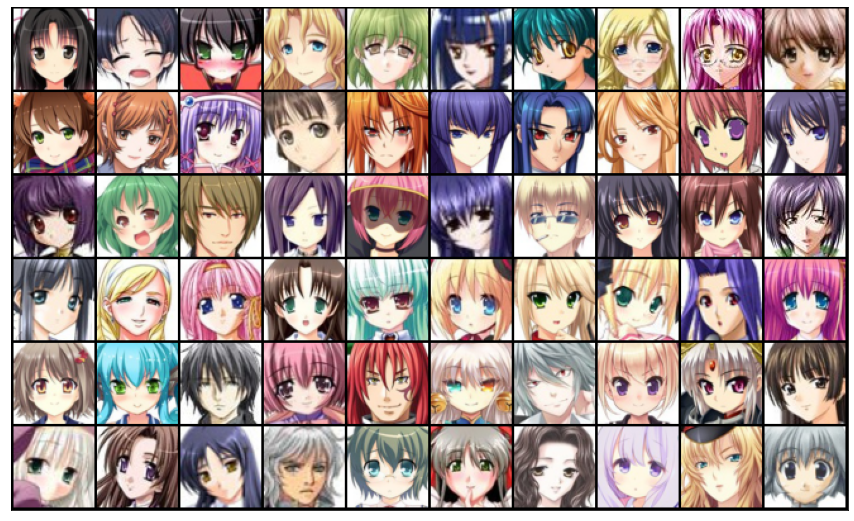

In [ ]:
# Let see the image from the dataset
show_batch(train_loader)

# Using GPUs

These are some function which help me to use GPU for the porcessing and to shift the data as well

In [ ]:
import torch

In [ ]:
def get_device():
  if torch.cuda.is_available:
    return ('cuda')
  else:
    return ('cpu')

def to_device(data, device):
  if isinstance(data, (tuple, list)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking= True)

class DeviceDataLoader():
  def __init__(self, batch,device):
    self.dl= batch
    self.device= device

  def __iter__(self):
    for b in self.dl:
      yield to_device (b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
torch.cuda.empty_cache()

# Discriminator Network
Used to predict wheather images is belong to dataset or generated by the image

Or just classify the image for between real image or the fake image 

In [ ]:
import torch.nn as nn

In [ ]:
# Creating the discriminator variable
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size= 4, padding= 1, stride= 2, bias= False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace= True),

    nn.Conv2d(64,128, kernel_size=4, stride= 2, padding= 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace= True),

    nn.Conv2d(128,256, kernel_size= 4, stride= 2, padding= 1, bias= False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace= True),

    nn.Conv2d(256,512, kernel_size= 4, stride= 2, padding= 1, bias= False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace= True),

    nn.Conv2d(512, 1, kernel_size= 4, stride= 1, padding= 0, bias= False),

    nn.Flatten(),
    nn.Sigmoid()
)

# Generator network
Used to generate the fake image on the basis of fake image

In [ ]:
latent_size= 128

In [ ]:
# Creating the Generator network
generator= nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size= 4, padding=0, stride= 1, bias= False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace= True),

    nn.ConvTranspose2d(512, 256, kernel_size= 4, padding=1, stride= 2, bias= False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace= True),

    nn.ConvTranspose2d(256, 156, kernel_size= 4, padding=1, stride= 2, bias= False),
    nn.BatchNorm2d(156),
    nn.ReLU(inplace= True),

    nn.ConvTranspose2d(156, 64,kernel_size= 4, padding=1, stride= 2, bias= False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace= True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, padding= 1, stride= 2, bias= False),
    nn.Tanh()
)

In [ ]:
# Getting the avialabel device for the workspace
device= get_device()
device

'cuda'

In [ ]:
# moving the dataloader on device
train_loader= DeviceDataLoader(train_loader, device)

torch.Size([130, 3, 64, 64])


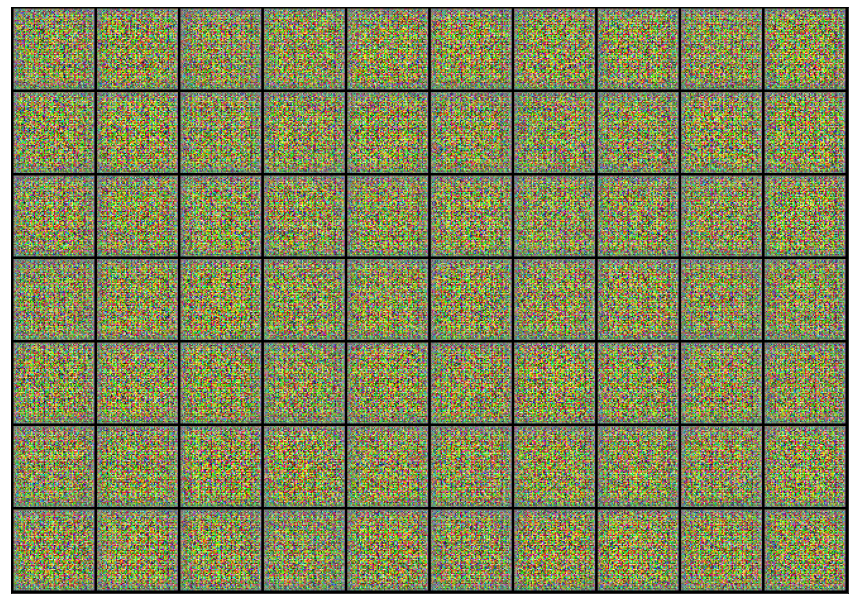

In [ ]:
# This is image formed using random numbers 
xb= torch.randn(batch_size, latent_size, 1, 1)
fake_image= generator(xb)
show_grid(fake_image)
print(fake_image.shape)

In [ ]:
# Moving the discrminator and genertor function on the device
to_device(discriminator, device)
to_device(generator, device)

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 156, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(156, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

# Training Discrminator and generator 

Loop For the number of epochs to train the discrminator as well as generator

In [ ]:
import torch.functional as F

In [ ]:
def train_discrminator(images, opt_d):
  opt_d.zero_grad()

  # Passing the real image and label for real image is 1
  real_preds= discriminator(images)
  real_target= torch.ones(images.size(0), 1, device= device)
  real_loss= F.binary_cross_entropy(real_preds, real_target)
  real_score= torch.mean(real_loss).item()

  # Generating the fake images
  latent= torch.randn(batch_size, latent_size, 1, 1, device= device)
  fake_image= generator(latent)

  # Passing the fake image and label is 0
  fake_target= torch.zeros(fake_image.size(0), 1, device= device)
  fake_preds= discriminator(fake_image)
  fake_loss= F.binary_cross_entropy(fake_preds, fake_target)
  fake_score= torch.mean(fake_loss).item()

  # Total loss of discrminator and increase the accuracy of the model
  loss= fake_loss + real_loss
  loss.backward()
  opt_d.step()

  return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
  opt_g.zero_grad()

  # Creating the vector to generate the images
  latent= torch.randn(batch_size, latent_size, 1, 1, device= device)
  fake_image= generator(latent)

  # Taking prediction and setting the label as 1 (as we want real images from the genertor)
  pred= discriminator(fake_image)
  target= torch.ones(batch_size, 1, device= device)
  loss= F.binary_cross_entropy(pred, target)

  loss.backward()
  opt_g.step()

  return loss.item()

In [ ]:
# Creating the directory to store the progress of the model
sample_dir= 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
# Saving the images and plot them 
from torchvision.utils import save_image

def saving_image(index, latent_tensor, show= True):
  fake_image= generator(latent_tensor)
  fake_name= 'generated-image-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_image), os.path.join(sample_dir, fake_name), nrow= 10)
  print('Saving', fake_name)
  if show:
    fig, ax= plt.subplots(figsize= (12,12))
    ax.set_xticks([]), ax.set_yticks([])
    plt.imshow(make_grid(fake_image.cpu().detach(), nrow= 10).permute(1,2,0))

In [ ]:
# This fixed_latent is used to see the progress of the model
fixed_latent= torch.randn(batch_size, 128, 1, 1, device= device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-image-0000.png


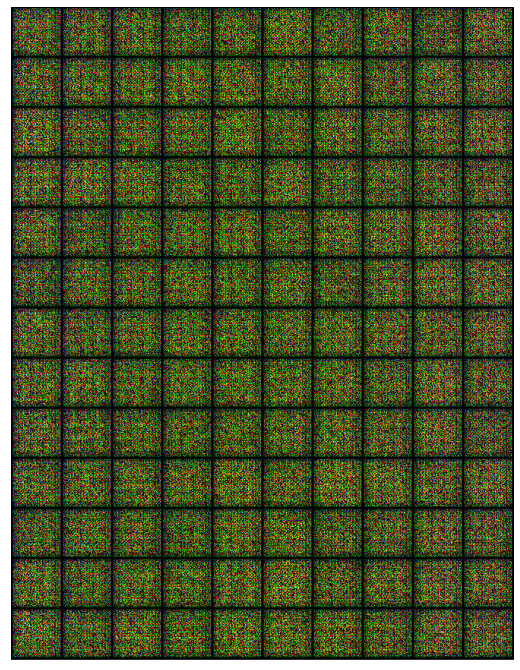

In [ ]:
# Now saving the image produce by this fixed_latent vector
saving_image(0, fixed_latent)

# Full training loop for the model
Fit method which iterate the train generator and discrimniator method to train the model

And help to generate the fake images which look a like real one

In [ ]:
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [ ]:
def fit(epochs, lr, idx=1):

  torch.cuda.empty_cache()

  # To record the losses
  losses_g= []
  losses_d= []
  fake_score= []
  real_score= []

  opt_g= torch.optim.Adam(generator.parameters(), lr, betas=(0.5, 0.996))
  opt_d= torch.optim.Adam(discriminator.parameters(), lr, betas=(0.5, 0.996))
  
  for epoch in range(epochs):

    for real_image, _ in tqdm(train_loader):
      loss_d, real_s, fake_s= train_discrminator(real_image, opt_d)
      loss_g= train_generator(opt_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_score.append(real_s)
    fake_score.append(fake_s)

    print('Epochs: [{}], loss_gen: {:.4f}, loss_dis: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}'.format(epoch, loss_g, loss_d, real_s, fake_s))

    saving_image(idx+epoch, fixed_latent, show= False)

  return losses_g, losses_d, real_score, fake_score

In [ ]:
jovian.commit(project= project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/lakshaygola/gans-anime-faces


'https://jovian.ai/lakshaygola/gans-anime-faces'

In [ ]:
# Defining hpyerparameteres
lr= 0.001
epochs= 30

In [ ]:
jovian.reset()
jovian.log_hyperparams(learning_rate= lr, epochs= epochs)

[jovian] Hyperparams logged.


In [ ]:
%%time
history= fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epochs: [0], loss_gen: 14.2536, loss_dis: 4.8770, real_score: 0.0082, fake_score: 4.8687
Saving generated-image-0001.png



Epochs: [1], loss_gen: 8.6001, loss_dis: 3.9554, real_score: 3.9553, fake_score: 0.0001
Saving generated-image-0002.png



Epochs: [2], loss_gen: 8.6660, loss_dis: 0.6968, real_score: 0.6961, fake_score: 0.0007
Saving generated-image-0003.png



Epochs: [3], loss_gen: 5.6123, loss_dis: 0.0915, real_score: 0.0202, fake_score: 0.0713
Saving generated-image-0004.png



Epochs: [4], loss_gen: 15.3372, loss_dis: 0.5948, real_score: 0.0038, fake_score: 0.5910
Saving generated-image-0005.png



Epochs: [5], loss_gen: 5.5240, loss_dis: 0.0196, real_score: 0.0006, fake_score: 0.0190
Saving generated-image-0006.png



Epochs: [6], loss_gen: 5.4486, loss_dis: 0.0445, real_score: 0.0061, fake_score: 0.0384
Saving generated-image-0007.png



Epochs: [7], loss_gen: 15.1519, loss_dis: 1.1701, real_score: 1.1701, fake_score: 0.0000
Saving generated-image-0008.png



Epochs: [8], loss_gen: 5.5217, loss_dis: 0.0820, real_score: 0.0635, fake_score: 0.0184
Saving generated-image-0009.png



Epochs: [9], loss_gen: 12.8128, loss_dis: 0.3407, real_score: 0.0003, fake_score: 0.3404
Saving generated-image-0010.png



Epochs: [10], loss_gen: 6.7682, loss_dis: 0.1308, real_score: 0.0535, fake_score: 0.0773
Saving generated-image-0011.png



Epochs: [11], loss_gen: 14.9639, loss_dis: 0.0045, real_score: 0.0040, fake_score: 0.0004
Saving generated-image-0012.png



Epochs: [12], loss_gen: 10.2738, loss_dis: 0.0642, real_score: 0.0578, fake_score: 0.0064
Saving generated-image-0013.png



Epochs: [13], loss_gen: 3.8721, loss_dis: 0.3000, real_score: 0.2941, fake_score: 0.0059
Saving generated-image-0014.png



Epochs: [14], loss_gen: 4.3361, loss_dis: 0.1088, real_score: 0.0731, fake_score: 0.0358
Saving generated-image-0015.png



Epochs: [15], loss_gen: 6.4516, loss_dis: 0.0521, real_score: 0.0088, fake_score: 0.0434
Saving generated-image-0016.png



Epochs: [16], loss_gen: 5.5195, loss_dis: 0.0877, real_score: 0.0733, fake_score: 0.0143
Saving generated-image-0017.png



Epochs: [17], loss_gen: 15.8367, loss_dis: 0.4803, real_score: 0.0044, fake_score: 0.4758
Saving generated-image-0018.png



Epochs: [18], loss_gen: 6.3270, loss_dis: 0.0662, real_score: 0.0544, fake_score: 0.0118
Saving generated-image-0019.png



Epochs: [19], loss_gen: 4.0186, loss_dis: 0.2356, real_score: 0.2142, fake_score: 0.0214
Saving generated-image-0020.png



Epochs: [20], loss_gen: 6.9183, loss_dis: 0.0987, real_score: 0.0537, fake_score: 0.0449
Saving generated-image-0021.png



Epochs: [21], loss_gen: 7.5559, loss_dis: 0.1579, real_score: 0.1029, fake_score: 0.0550
Saving generated-image-0022.png



Epochs: [22], loss_gen: 7.0783, loss_dis: 0.0634, real_score: 0.0451, fake_score: 0.0183
Saving generated-image-0023.png



Epochs: [23], loss_gen: 9.1052, loss_dis: 0.1088, real_score: 0.0216, fake_score: 0.0872
Saving generated-image-0024.png



Epochs: [24], loss_gen: 4.6536, loss_dis: 0.4825, real_score: 0.4823, fake_score: 0.0001
Saving generated-image-0025.png



Epochs: [25], loss_gen: 7.1705, loss_dis: 0.1041, real_score: 0.0124, fake_score: 0.0917
Saving generated-image-0026.png



Epochs: [26], loss_gen: 7.1171, loss_dis: 0.0361, real_score: 0.0270, fake_score: 0.0090
Saving generated-image-0027.png



Epochs: [27], loss_gen: 6.3879, loss_dis: 0.1479, real_score: 0.1393, fake_score: 0.0086
Saving generated-image-0028.png



Epochs: [28], loss_gen: 2.0878, loss_dis: 1.6208, real_score: 1.6208, fake_score: 0.0000
Saving generated-image-0029.png



Epochs: [29], loss_gen: 6.0598, loss_dis: 0.1591, real_score: 0.0952, fake_score: 0.0639
Saving generated-image-0030.png
CPU times: user 37min 22s, sys: 30min 1s, total: 1h 7min 23s
Wall time: 1h 8min 50s


In [ ]:
losses_g, losses_d, real_score, fake_score= history

In [ ]:
history

In [ ]:
jovian.log_metrics(loss_g= losses_g[-1],
                   loss_d= losses_d[-1],
                   real_score= real_score[-1],
                   fake_score= fake_score[-1])

[jovian] Metrics logged.


In [ ]:
# Saving the weight of the model
torch.save(generator.state_dict, 'Generator.pth')
torch.save(discriminator.state_dict, 'Discrminator.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-image-0001.png


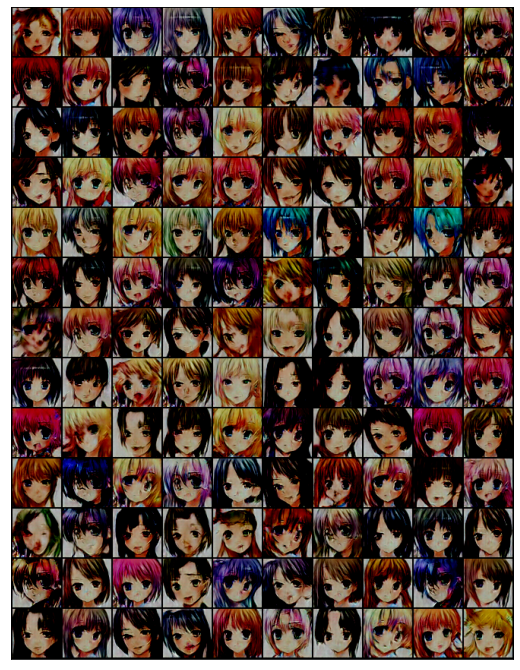

In [ ]:
saving_image(1, fixed_latent)

# Creating the video so we can see the progress of the model
For this i am using CV2 library to create the video

In [ ]:
import cv2
import os

vid_fname = 'gans_animef_training.mp4'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

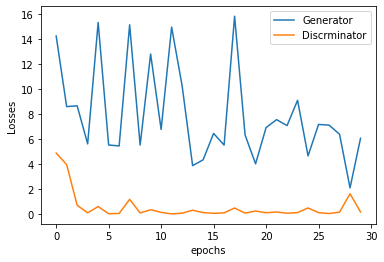

In [ ]:
# Plotting the losses of the generator and the discrminator
plt.plot(losses_g)
plt.plot(losses_d)
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.legend(['Generator', 'Discrminator'])

Text(0, 0.5, 'Real_score')

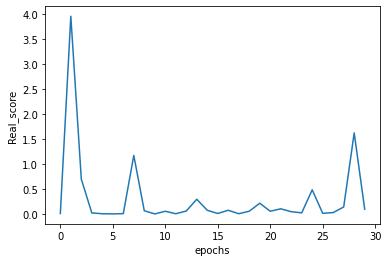

In [ ]:
# Plotting the real_score of the model
plt.plot(real_score)
plt.xlabel('epochs')
plt.ylabel('Real_score')

Text(0, 0.5, 'Real_score')

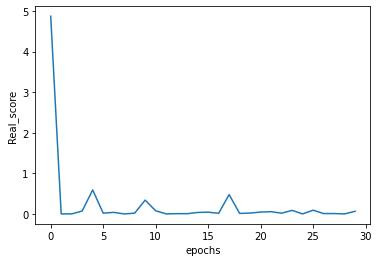

In [ ]:
# Plotting the fake_score of the model
plt.plot(fake_score)
plt.xlabel('epochs')
plt.ylabel('Real_score')

In [ ]:
# Commiting the changes 
jovian.commit(project= project_name, outputs= ['Generator.pth', 'Discrminator.pth', 'gans_animef_training.avi'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Uploading additional outputs...


[jovian] Error: Ignoring "gans_animef_training.avi" (not found)


[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/lakshaygola/gans-anime-faces


'https://jovian.ai/lakshaygola/gans-anime-faces'